In [1]:
import json

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba, to_hex

import pandas as pd
import numpy as np
import umap
from openai import OpenAI
import warnings

# Suppress all UserWarnings because umap is annoying
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('race_names.csv')
df.sample(10)

,first_name,last_name,race5,frequency
3249,BILLY,ADAMS,White,11
22186,MATTHEW,MCCOY,White,24
5190,CHARLES,REID,White,13
11108,HANNAH,STONE,White,17
12390,JAMES,HUDSON,White,62
7311,DANIEL,LEE,Asian,23
16986,JOSHUA,CHAPMAN,White,28
30732,THOMAS,FARRELL,White,13
17256,JOSHUA,ROBERTS,White,50
11625,JACOB,CAMPBELL,White,23


Split the dataset to get random samples for training and testing, but only allow a last name to appear once.

In [3]:


# Define the proportion for the training set
train_proportion = 0.40
test_proportion = 0.40 

# Get unique last names to ensure they are exclusive between training and test sets
unique_last_names = df['last_name'].unique()

# Shuffle the unique last names to randomize the order
np.random.shuffle(unique_last_names)

# Calculate the number of unique last names to include in each set
num_train = int(np.floor(train_proportion * len(unique_last_names)))
num_test = int(np.floor(test_proportion * len(unique_last_names)))

# Split the unique last names into training and testing sets
train_last_names = unique_last_names[:num_train]
test_last_names = unique_last_names[num_train:num_train + num_test]

# Remaining last names for a possible validation set or to be unused
unused_last_names = unique_last_names[num_train + num_test:]

# Create masks for the training and testing sets
train_mask = df['last_name'].isin(train_last_names)
test_mask = df['last_name'].isin(test_last_names)

# Now that we have the last names for each set, we can sample the first names weighted by frequency
# For the training set
train_sample = df[train_mask].sample(n=3000, weights=train_mask.astype(int) * df['frequency'], replace=False)
train_sample['sample'] = 'Train'
# For the test set, we ensure no last names from the training set are included
test_sample = df[test_mask].sample(n=3000, weights=test_mask.astype(int) * df['frequency'], replace=False)
test_sample['sample'] = 'Test'

df_sample = pd.concat([train_sample,test_sample])

In [4]:

# Expand the dataset by the 'frequency' values
expanded_df = pd.DataFrame(
    np.repeat(df.values, df['frequency'], axis=0), 
    columns=df.columns
)

# Shuffle the expanded DataFrame to randomize rows before labeling
expanded_df = expanded_df.sample(frac=1).reset_index(drop=True)

# Assuming you want exactly 3K labeled as 'Train' and 3K as 'Test', 
# and the dataset is large enough to accommodate this:
train_df = expanded_df.iloc[:3000].copy()
test_df = expanded_df.iloc[3000:6000].copy()

# Assign the labels
train_df['sample'] = 'Train'
test_df['sample'] = 'Test'

# Concatenate the two DataFrames back together
df_sample = pd.concat([train_df, test_df])

In [5]:
df_sample['name'] = df_sample['first_name'] + ' ' + df_sample['last_name']
df_sample["name"] = df_sample["name"].str.title()

Next, I get the embeddings for the three models of interest. `text-embedding-ada-002` and `text-embedding-3-small` but represent texts in 1,536 dimensions, while `text-embedding-3-large` has twice as many. This is hard to plot, so, following the good folks at Bloomberg, I use UMAP to reduce this down to just two dimensions for each embedding model. I also tried a different algorithm, TSNE with very similar results. 

In [13]:
def get_open_embeddings(text_list, model="text-embedding-3-large"):
    client = OpenAI(max_retries=3)
    """Fetches embeddings for a list of texts using the specified model."""
    embeddings_response = client.embeddings.create(input=text_list, model=model)
    return [text.embedding for text in embeddings_response.data]


def reduce_dimensions(
    df, embedding_column, n_components=2, random_state=42, n_neighbors=30, min_dist=0.9
):
    """Reduces the dimensions of embeddings to 2D using UMAP."""
    embeddings = np.vstack(df[embedding_column])
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    reduced_embeddings = reducer.fit_transform(embeddings)
    df[f"{embedding_column}_umap_x"], df[f"{embedding_column}_umap_y"] = (
        reduced_embeddings.T
    )
    return df, reducer


# Main code
for model in [
    "text-embedding-3-small",
]:

    if model not in df_sample.keys():
        names = sample_df["name"].tolist()
        name_df[model] = get_open_embeddings(names, model=model)
    df_sample, umap_reducer = reduce_dimensions(df_sample, model)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
def get_open_embeddings(text_list, model="text-embedding-3-small"):
    client = OpenAI(max_retries=3)
    """Fetches embeddings for a list of texts using the specified model."""
    embeddings_response = client.embeddings.create(input=text_list, model=model)
    return [text.embedding for text in embeddings_response.data]


def reduce_dimensions(
    df, embedding_column, n_components=2, random_state=42, n_neighbors=30, min_dist=0.9
):
    """Reduces the dimensions of embeddings to 2D using UMAP."""
    embeddings = np.vstack(df[embedding_column])
    reducer = umap.UMAP(
        n_components=n_components,
        random_state=random_state,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    reduced_embeddings = reducer.fit_transform(embeddings)
    df[f"{embedding_column}_umap_x"], df[f"{embedding_column}_umap_y"] = (
        reduced_embeddings.T
    )
    return df, reducer


# Main code
for model in [
    "text-embedding-3-small",
]:

    if model not in sample_df.keys():
        names = sample_df["name"].tolist()
        name_df[model] = get_open_embeddings(names, model=model)
    sample_df, umap_reducer = reduce_dimensions(sample_df, model)

NameError: name 'sample_df' is not defined

Finally, plot them. I added gender to the mix by showing women's names with a darker hue.

In [14]:


# Base colors for races
race2color = {
    "White": "#c71e1d",
    "Black": "#fa8c00",
    "Asian": "#009076",
    "Hispanic or Latino": "#15607a",
    "Other": "grey",
}

def plot_names(name_df = 'df', model='text-embedding-3-small'):
    # Extend race2color with darker shades for females

    # Extract UMAP coordinates, names, races, and sexes
    umap_x = name_df[f"{model}_umap_x"].values
    umap_y = name_df[f"{model}_umap_y"].values
    races = name_df["race5"].values
    #sexes = name_df["sex"].values

    # Determine color based on race and sex
    colors = [
        race2color[race] for race in races
    ]

    # Create the plot
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.scatter(umap_x, umap_y, color=colors, alpha=0.5)

    for x, y, name, color in zip(umap_x, umap_y, names, colors):
        ax.annotate(name, (x, y), color=color, size=8, ha="center", va="bottom")
    # Enhancements
    ax.set_title(f"UMAP projection of {model} Embeddings by Race", fontsize=16)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_axisbelow(True)

    # Optional: Remove the x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

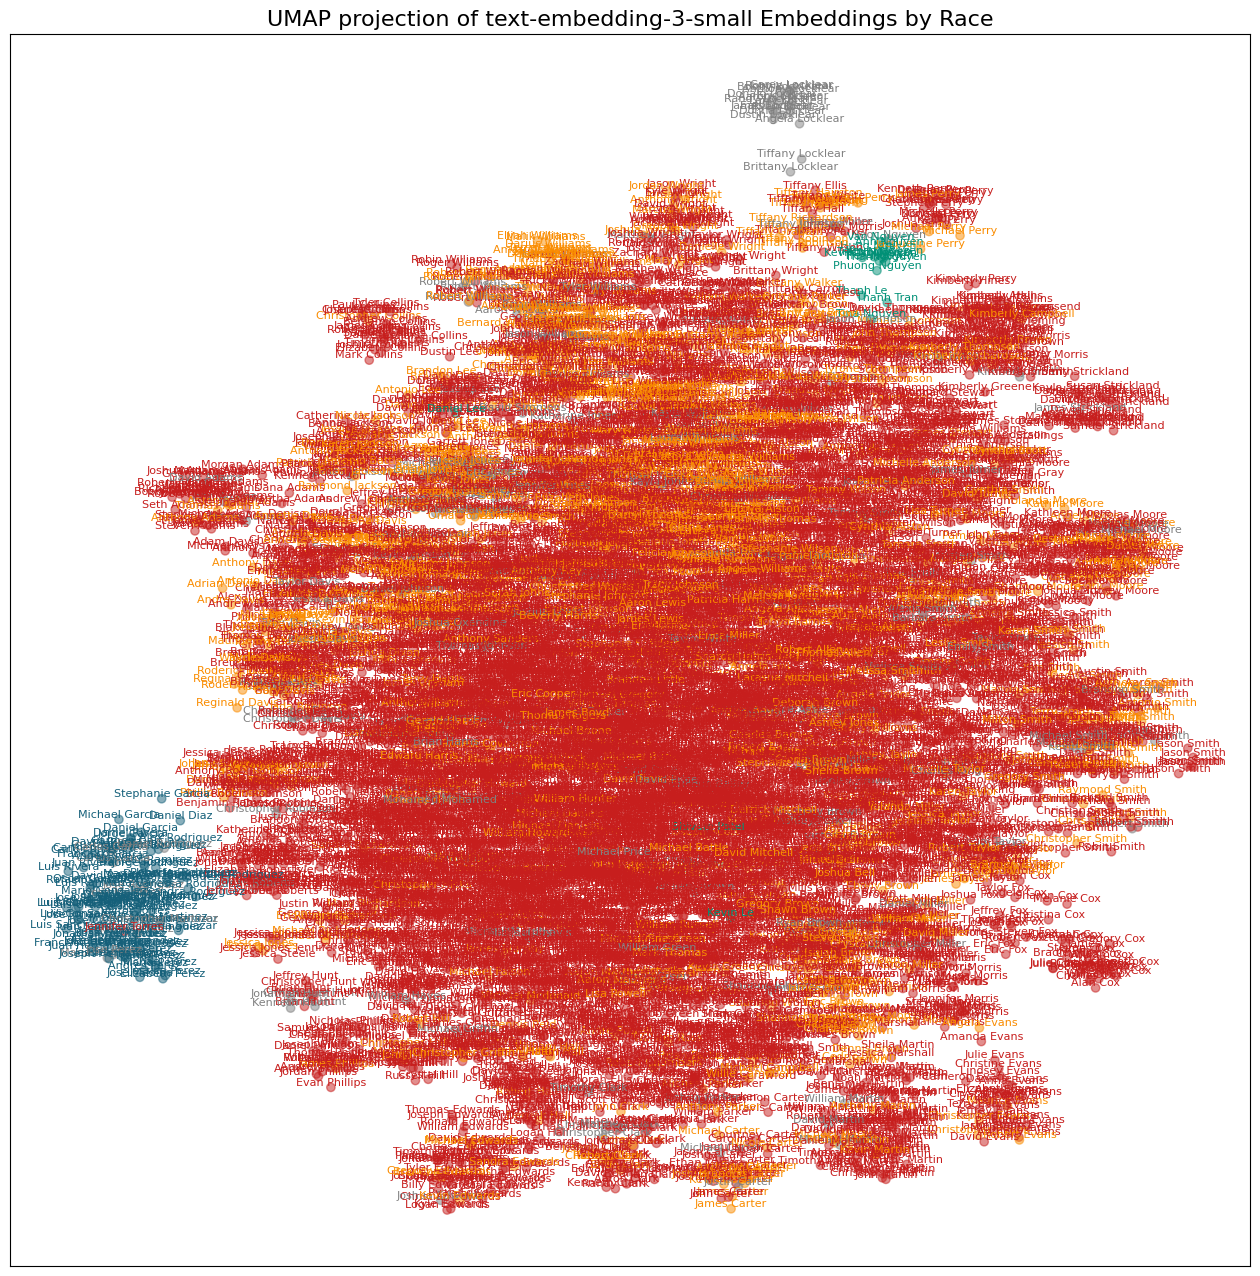

In [15]:
plot_names(df_sample, model)

Back when I thought it would be useful, I also tried to model how many embedding dimensions it would take, leveraging the fact that the two new OpenAI models apparently put all the interesting ones up from. Results do seem to confirm that, but again, with only 20 last names, I don't make too much of this.

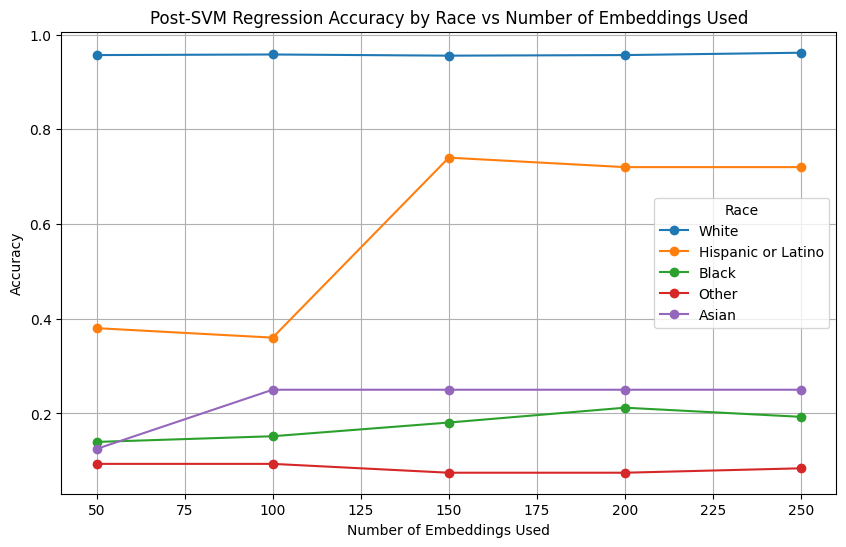

In [18]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score


def train_and_evaluate_svm_for_race_accuracy(df, embeddings_column, target_column, max_columns):
    columns_used = list(range(50, max_columns + 1, 50))
    race_accuracies = {race: [] for race in df[target_column].unique()}
    
    label_encoder = LabelEncoder()
    df['y_encoded'] = label_encoder.fit_transform(df[target_column])
    train_df = df[df['sample'] == 'Train']
    test_df = df[df['sample'] == 'Test']
    test_races = test_df[target_column]
    
    for num_embeddings in columns_used:
        X_train = np.array(train_df[embeddings_column].apply(lambda x: x[:num_embeddings]).tolist())
        y_train = train_df['y_encoded'].values
        
        X_test = np.array(test_df[embeddings_column].apply(lambda x: x[:num_embeddings]).tolist())
        y_test = test_df['y_encoded'].values
        
        #clf = SVC(kernel='rbf', C=10, random_state=42,class_weight='balanced')
        #
        clf = xgb.XGBClassifier(objective='multi:softprob', num_class=5, eval_metric="mlogloss", use_label_encoder=False)
        clf.fit(X_train, y_train)


        y_pred = clf.predict(X_test)
        
        # Instead of using DataFrame indices, we'll use boolean masks for each race
        for race in df[target_column].value_counts().index:
            race_mask = (test_races == race)  # Create a boolean mask for the current race
            if race_mask.sum() > 0:  # Check if there are any samples for the current race
                race_accuracy = accuracy_score(y_test[race_mask], y_pred[race_mask])
                race_accuracies[race].append(race_accuracy)
            else:
                # Handle case where there might be no samples for a race in the test set
                race_accuracies[race].append(None)
    
    return race_accuracies, columns_used

# Make sure to replace 'df_sample', 'embeddings_column', and 'race5' with actual variable names as applicable
race_accuracies, columns_used = train_and_evaluate_svm_for_race_accuracy(df_sample, model, 'race5', 250)

# Plotting the accuracies for each race
plt.figure(figsize=(10, 6))
for race, accuracies in race_accuracies.items():
    # Skip plotting for races with no data
    if not all(accuracy is None for accuracy in accuracies):
        plt.plot(columns_used, accuracies, marker='o', linestyle='-', label=race)

plt.title('Post-SVM Regression Accuracy by Race vs Number of Embeddings Used')
plt.xlabel('Number of Embeddings Used')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(title="Race")
plt.show()


In [38]:
df['race5']

Index(['White', 'Black', 'Other', 'Hispanic or Latino', 'Asian'], dtype='object', name='race5')